# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory  = directory
        self.imgs = glob(directory + '*' + extension)
        self.transforms = transforms
        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.imgs)
        
    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        
        # TODO: return the index-element of the dataset
        img = self.transforms(Image.open(self.imgs[index]))
        return img

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

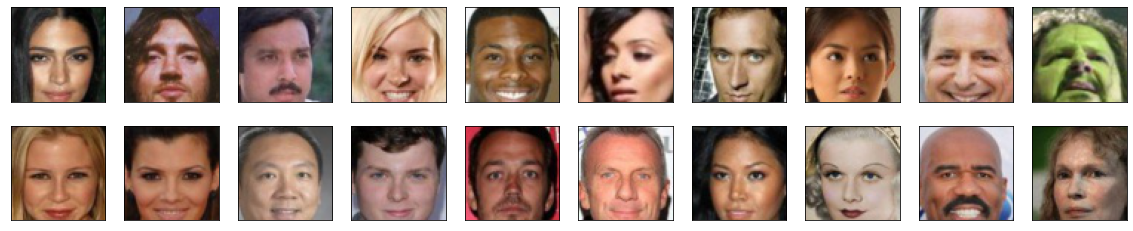

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch.nn as nn

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        # complete init function
        conv_dim = conv_dim = 64
        self.conv1 = ConvBlock(3, conv_dim, 4, 2 , 1, batch_norm=False) # first layer, no batch_norm
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4, 2, 1, batch_norm=True)
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4, 2, 1, batch_norm=True)
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4, 2, 1, batch_norm=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(conv_dim*4*4*4*2, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(self.flatten(x))
        x = x.view(-1,1,1,1)
        return x

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [12]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        # TODO: instantiate the different layers
        super(Generator, self).__init__()
        conv_dim = 64
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*8, 4, 1, 0) 
        self.deconv2 = DeconvBlock(conv_dim*8, conv_dim*4, 4, 2, 1) 
        self.deconv3 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1) 
        self.deconv4 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1) 
        self.deconv5 = nn.ConvTranspose2d(in_channels = conv_dim, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, bias = False) 
        self.last_activation = nn.Tanh()
        
        
    def forward(self, x):
        # TODO: implement the forward method
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
        return x

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim
def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002
    beta1=0.5
    beta2=0.999 # default value
    # Create optimizers for the discriminator and generator
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits, smooth  = True):
    """ Generator loss, takes the fake scores as inputs. """
  
    # Implement the generator loss 
    ## Real losses
    batch_size = fake_logits.size(0)
    if smooth:     
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    labels = labels.to(device)   
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(fake_logits.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits, smooth = True):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # Implement the discriminator loss 
    
    ## Real losses
    batch_size = real_logits.size(0)
    
    if smooth:    
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    real_loss = criterion(real_logits.squeeze(), labels)
    
    ## Fake losses
    batch_size_f = fake_logits.size(0)   
    labels_f = torch.zeros(batch_size_f).to(device)        
    fake_loss = criterion(fake_logits.squeeze(), labels_f)
    
    loss = real_loss + fake_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake) # use real loss to flip labels
    g_loss.backward()
    g_optimizer.step()
        
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    D_real = discriminator(real_images)
    
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)

    D_fake = discriminator(fake_images.detach())
    
    d_loss = discriminator_loss(D_real,D_fake) 
    d_loss.backward()
    d_optimizer.step()
    gp = 0
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [20]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-11-24 10:30:17 | Epoch [1/20] | Batch 0/509 | d_loss: 2.7399 | g_loss: 0.5359
2023-11-24 10:30:23 | Epoch [1/20] | Batch 50/509 | d_loss: 0.3889 | g_loss: 9.4148
2023-11-24 10:30:30 | Epoch [1/20] | Batch 100/509 | d_loss: 0.4534 | g_loss: 7.7662
2023-11-24 10:30:36 | Epoch [1/20] | Batch 150/509 | d_loss: 0.5276 | g_loss: 3.8440
2023-11-24 10:30:43 | Epoch [1/20] | Batch 200/509 | d_loss: 0.7358 | g_loss: 4.7130
2023-11-24 10:30:50 | Epoch [1/20] | Batch 250/509 | d_loss: 0.9337 | g_loss: 1.6643
2023-11-24 10:30:56 | Epoch [1/20] | Batch 300/509 | d_loss: 0.7125 | g_loss: 2.7669
2023-11-24 10:31:03 | Epoch [1/20] | Batch 350/509 | d_loss: 0.8693 | g_loss: 4.5358
2023-11-24 10:31:10 | Epoch [1/20] | Batch 400/509 | d_loss: 0.6117 | g_loss: 3.2806
2023-11-24 10:31:16 | Epoch [1/20] | Batch 450/509 | d_loss: 0.6009 | g_loss: 5.5407
2023-11-24 10:31:23 | Epoch [1/20] | Batch 500/509 | d_loss: 0.9322 | g_loss: 2.1184


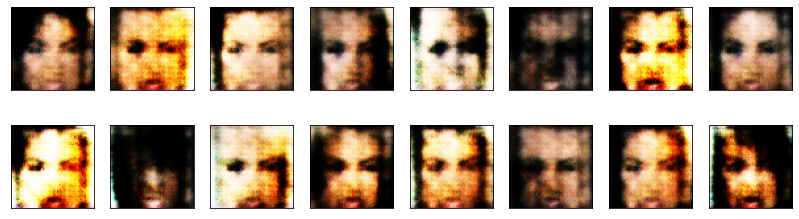

2023-11-24 10:31:27 | Epoch [2/20] | Batch 0/509 | d_loss: 0.7396 | g_loss: 4.3126
2023-11-24 10:31:34 | Epoch [2/20] | Batch 50/509 | d_loss: 0.7057 | g_loss: 2.8718
2023-11-24 10:31:40 | Epoch [2/20] | Batch 100/509 | d_loss: 0.6835 | g_loss: 3.9287
2023-11-24 10:31:47 | Epoch [2/20] | Batch 150/509 | d_loss: 1.4522 | g_loss: 1.3693
2023-11-24 10:31:53 | Epoch [2/20] | Batch 200/509 | d_loss: 0.9584 | g_loss: 2.7412
2023-11-24 10:32:00 | Epoch [2/20] | Batch 250/509 | d_loss: 0.5407 | g_loss: 3.4547
2023-11-24 10:32:06 | Epoch [2/20] | Batch 300/509 | d_loss: 0.7456 | g_loss: 2.8722
2023-11-24 10:32:12 | Epoch [2/20] | Batch 350/509 | d_loss: 0.6223 | g_loss: 3.6546
2023-11-24 10:32:19 | Epoch [2/20] | Batch 400/509 | d_loss: 0.9063 | g_loss: 4.9556
2023-11-24 10:32:25 | Epoch [2/20] | Batch 450/509 | d_loss: 0.7650 | g_loss: 4.1271
2023-11-24 10:32:32 | Epoch [2/20] | Batch 500/509 | d_loss: 0.6934 | g_loss: 2.5661


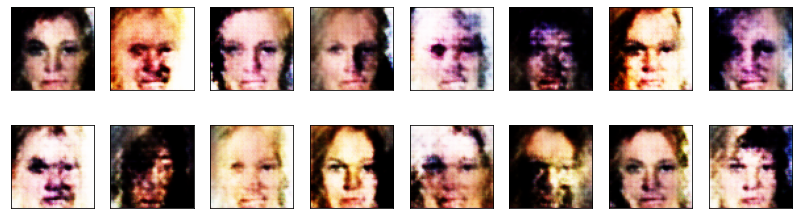

2023-11-24 10:32:36 | Epoch [3/20] | Batch 0/509 | d_loss: 0.8390 | g_loss: 4.4973
2023-11-24 10:32:43 | Epoch [3/20] | Batch 50/509 | d_loss: 1.0536 | g_loss: 2.0534
2023-11-24 10:32:50 | Epoch [3/20] | Batch 100/509 | d_loss: 0.8113 | g_loss: 4.3989
2023-11-24 10:32:56 | Epoch [3/20] | Batch 150/509 | d_loss: 0.5812 | g_loss: 2.8962
2023-11-24 10:33:03 | Epoch [3/20] | Batch 200/509 | d_loss: 0.9250 | g_loss: 2.4887
2023-11-24 10:33:09 | Epoch [3/20] | Batch 250/509 | d_loss: 0.8560 | g_loss: 1.9704
2023-11-24 10:33:16 | Epoch [3/20] | Batch 300/509 | d_loss: 0.6892 | g_loss: 4.1255
2023-11-24 10:33:23 | Epoch [3/20] | Batch 350/509 | d_loss: 0.6350 | g_loss: 2.6346
2023-11-24 10:33:29 | Epoch [3/20] | Batch 400/509 | d_loss: 0.8950 | g_loss: 2.2211
2023-11-24 10:33:36 | Epoch [3/20] | Batch 450/509 | d_loss: 0.6249 | g_loss: 2.4613
2023-11-24 10:33:42 | Epoch [3/20] | Batch 500/509 | d_loss: 0.5059 | g_loss: 3.3823


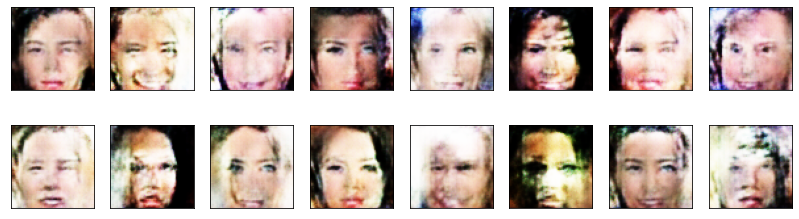

2023-11-24 10:33:48 | Epoch [4/20] | Batch 0/509 | d_loss: 0.8130 | g_loss: 4.8141
2023-11-24 10:33:54 | Epoch [4/20] | Batch 50/509 | d_loss: 0.6378 | g_loss: 3.4657
2023-11-24 10:34:01 | Epoch [4/20] | Batch 100/509 | d_loss: 0.6780 | g_loss: 4.8061
2023-11-24 10:34:07 | Epoch [4/20] | Batch 150/509 | d_loss: 0.5086 | g_loss: 3.3850
2023-11-24 10:34:13 | Epoch [4/20] | Batch 200/509 | d_loss: 0.4503 | g_loss: 4.5348
2023-11-24 10:34:20 | Epoch [4/20] | Batch 250/509 | d_loss: 1.8860 | g_loss: 6.3811
2023-11-24 10:34:26 | Epoch [4/20] | Batch 300/509 | d_loss: 1.0946 | g_loss: 1.6372
2023-11-24 10:34:33 | Epoch [4/20] | Batch 350/509 | d_loss: 1.3589 | g_loss: 6.3087
2023-11-24 10:34:39 | Epoch [4/20] | Batch 400/509 | d_loss: 0.6253 | g_loss: 4.0437
2023-11-24 10:34:46 | Epoch [4/20] | Batch 450/509 | d_loss: 0.4677 | g_loss: 3.1715
2023-11-24 10:34:53 | Epoch [4/20] | Batch 500/509 | d_loss: 1.5529 | g_loss: 6.4696


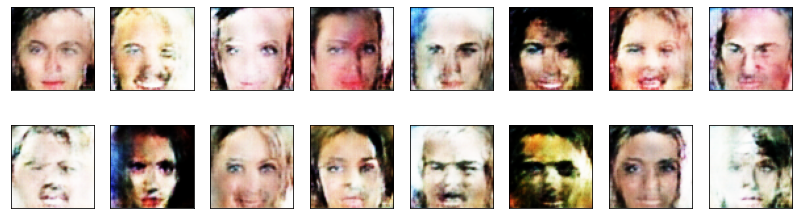

2023-11-24 10:34:59 | Epoch [5/20] | Batch 0/509 | d_loss: 0.5795 | g_loss: 2.5978
2023-11-24 10:35:05 | Epoch [5/20] | Batch 50/509 | d_loss: 0.5215 | g_loss: 3.6051
2023-11-24 10:35:12 | Epoch [5/20] | Batch 100/509 | d_loss: 0.5013 | g_loss: 2.9735
2023-11-24 10:35:18 | Epoch [5/20] | Batch 150/509 | d_loss: 0.7271 | g_loss: 2.8726
2023-11-24 10:35:25 | Epoch [5/20] | Batch 200/509 | d_loss: 0.7075 | g_loss: 3.4904
2023-11-24 10:35:31 | Epoch [5/20] | Batch 250/509 | d_loss: 0.5718 | g_loss: 3.4492
2023-11-24 10:35:38 | Epoch [5/20] | Batch 300/509 | d_loss: 0.8035 | g_loss: 2.2750
2023-11-24 10:35:44 | Epoch [5/20] | Batch 350/509 | d_loss: 0.5137 | g_loss: 2.3951
2023-11-24 10:35:50 | Epoch [5/20] | Batch 400/509 | d_loss: 0.5259 | g_loss: 2.9165
2023-11-24 10:35:57 | Epoch [5/20] | Batch 450/509 | d_loss: 0.7234 | g_loss: 4.5047
2023-11-24 10:36:03 | Epoch [5/20] | Batch 500/509 | d_loss: 0.6054 | g_loss: 3.4940


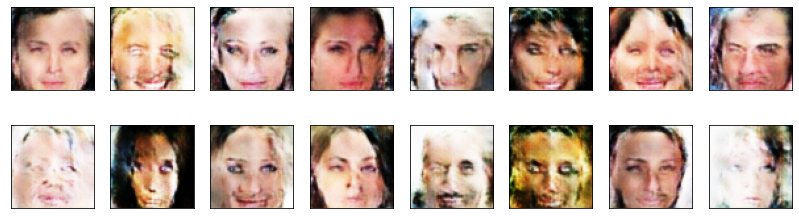

2023-11-24 10:36:08 | Epoch [6/20] | Batch 0/509 | d_loss: 0.7080 | g_loss: 3.2944
2023-11-24 10:36:15 | Epoch [6/20] | Batch 50/509 | d_loss: 0.5337 | g_loss: 3.5729
2023-11-24 10:36:21 | Epoch [6/20] | Batch 100/509 | d_loss: 1.6820 | g_loss: 5.7717
2023-11-24 10:36:27 | Epoch [6/20] | Batch 150/509 | d_loss: 0.6130 | g_loss: 2.3810
2023-11-24 10:36:34 | Epoch [6/20] | Batch 200/509 | d_loss: 0.7501 | g_loss: 2.2756
2023-11-24 10:36:41 | Epoch [6/20] | Batch 250/509 | d_loss: 0.4253 | g_loss: 3.8044
2023-11-24 10:36:47 | Epoch [6/20] | Batch 300/509 | d_loss: 0.5120 | g_loss: 3.1420
2023-11-24 10:36:54 | Epoch [6/20] | Batch 350/509 | d_loss: 0.6796 | g_loss: 3.9922
2023-11-24 10:37:01 | Epoch [6/20] | Batch 400/509 | d_loss: 0.5360 | g_loss: 3.4018
2023-11-24 10:37:07 | Epoch [6/20] | Batch 450/509 | d_loss: 0.4898 | g_loss: 2.7004
2023-11-24 10:37:14 | Epoch [6/20] | Batch 500/509 | d_loss: 0.4751 | g_loss: 2.8062


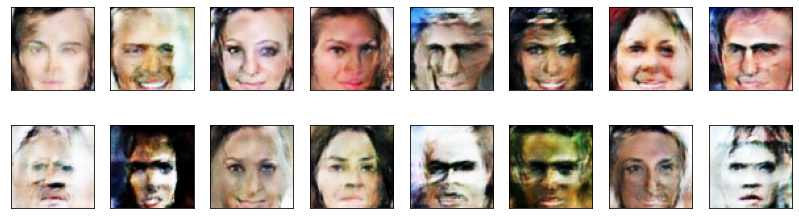

2023-11-24 10:37:19 | Epoch [7/20] | Batch 0/509 | d_loss: 1.0414 | g_loss: 1.9933
2023-11-24 10:37:25 | Epoch [7/20] | Batch 50/509 | d_loss: 0.6575 | g_loss: 4.7208
2023-11-24 10:37:31 | Epoch [7/20] | Batch 100/509 | d_loss: 0.5056 | g_loss: 3.7014
2023-11-24 10:37:38 | Epoch [7/20] | Batch 150/509 | d_loss: 1.1822 | g_loss: 5.4412
2023-11-24 10:37:44 | Epoch [7/20] | Batch 200/509 | d_loss: 0.8375 | g_loss: 4.2744
2023-11-24 10:37:51 | Epoch [7/20] | Batch 250/509 | d_loss: 0.4620 | g_loss: 3.2922
2023-11-24 10:37:57 | Epoch [7/20] | Batch 300/509 | d_loss: 0.9953 | g_loss: 2.5234
2023-11-24 10:38:03 | Epoch [7/20] | Batch 350/509 | d_loss: 0.5251 | g_loss: 4.2554
2023-11-24 10:38:10 | Epoch [7/20] | Batch 400/509 | d_loss: 0.5343 | g_loss: 3.5376
2023-11-24 10:38:16 | Epoch [7/20] | Batch 450/509 | d_loss: 0.4826 | g_loss: 1.9609
2023-11-24 10:38:22 | Epoch [7/20] | Batch 500/509 | d_loss: 0.9066 | g_loss: 3.2704


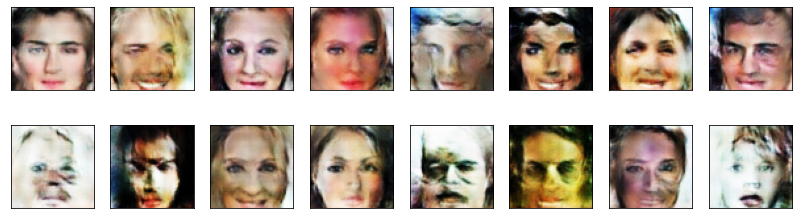

2023-11-24 10:38:27 | Epoch [8/20] | Batch 0/509 | d_loss: 0.4783 | g_loss: 2.4120
2023-11-24 10:38:34 | Epoch [8/20] | Batch 50/509 | d_loss: 1.0024 | g_loss: 3.2026
2023-11-24 10:38:40 | Epoch [8/20] | Batch 100/509 | d_loss: 0.4143 | g_loss: 4.8453
2023-11-24 10:38:47 | Epoch [8/20] | Batch 150/509 | d_loss: 0.4353 | g_loss: 3.4749
2023-11-24 10:38:54 | Epoch [8/20] | Batch 200/509 | d_loss: 1.4310 | g_loss: 5.3378
2023-11-24 10:39:00 | Epoch [8/20] | Batch 250/509 | d_loss: 0.4612 | g_loss: 3.4326
2023-11-24 10:39:07 | Epoch [8/20] | Batch 300/509 | d_loss: 0.4526 | g_loss: 3.5500
2023-11-24 10:39:14 | Epoch [8/20] | Batch 350/509 | d_loss: 1.2411 | g_loss: 5.2563
2023-11-24 10:39:20 | Epoch [8/20] | Batch 400/509 | d_loss: 0.4470 | g_loss: 4.2545
2023-11-24 10:39:26 | Epoch [8/20] | Batch 450/509 | d_loss: 0.5035 | g_loss: 4.2961
2023-11-24 10:39:33 | Epoch [8/20] | Batch 500/509 | d_loss: 0.4082 | g_loss: 4.2360


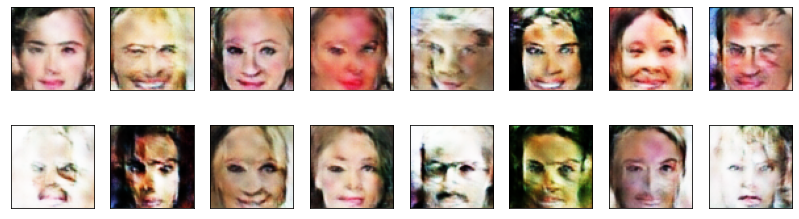

2023-11-24 10:39:38 | Epoch [9/20] | Batch 0/509 | d_loss: 0.6044 | g_loss: 3.2301
2023-11-24 10:39:44 | Epoch [9/20] | Batch 50/509 | d_loss: 0.6886 | g_loss: 3.6108
2023-11-24 10:39:51 | Epoch [9/20] | Batch 100/509 | d_loss: 0.3548 | g_loss: 3.2624
2023-11-24 10:39:57 | Epoch [9/20] | Batch 150/509 | d_loss: 0.3783 | g_loss: 3.3794
2023-11-24 10:40:03 | Epoch [9/20] | Batch 200/509 | d_loss: 0.4351 | g_loss: 3.9069
2023-11-24 10:40:10 | Epoch [9/20] | Batch 250/509 | d_loss: 0.4869 | g_loss: 4.0552
2023-11-24 10:40:16 | Epoch [9/20] | Batch 300/509 | d_loss: 0.5642 | g_loss: 3.4022
2023-11-24 10:40:23 | Epoch [9/20] | Batch 350/509 | d_loss: 0.3865 | g_loss: 4.4196
2023-11-24 10:40:29 | Epoch [9/20] | Batch 400/509 | d_loss: 0.6724 | g_loss: 3.1992
2023-11-24 10:40:36 | Epoch [9/20] | Batch 450/509 | d_loss: 0.5522 | g_loss: 4.9048
2023-11-24 10:40:43 | Epoch [9/20] | Batch 500/509 | d_loss: 0.5819 | g_loss: 4.6662


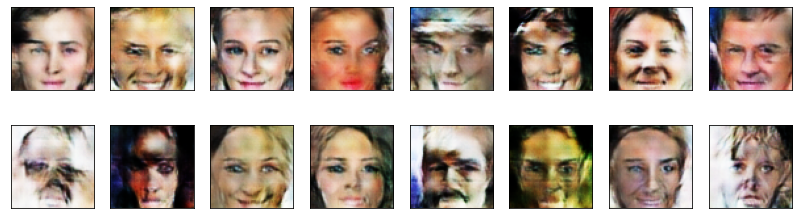

2023-11-24 10:40:48 | Epoch [10/20] | Batch 0/509 | d_loss: 0.4340 | g_loss: 4.3793
2023-11-24 10:40:54 | Epoch [10/20] | Batch 50/509 | d_loss: 3.2533 | g_loss: 6.4868
2023-11-24 10:41:01 | Epoch [10/20] | Batch 100/509 | d_loss: 0.4723 | g_loss: 3.5360
2023-11-24 10:41:08 | Epoch [10/20] | Batch 150/509 | d_loss: 0.4563 | g_loss: 4.8793
2023-11-24 10:41:14 | Epoch [10/20] | Batch 200/509 | d_loss: 0.3859 | g_loss: 3.1083
2023-11-24 10:41:21 | Epoch [10/20] | Batch 250/509 | d_loss: 0.5085 | g_loss: 4.3674
2023-11-24 10:41:27 | Epoch [10/20] | Batch 300/509 | d_loss: 0.4847 | g_loss: 3.8395
2023-11-24 10:41:34 | Epoch [10/20] | Batch 350/509 | d_loss: 0.4792 | g_loss: 3.2597
2023-11-24 10:41:40 | Epoch [10/20] | Batch 400/509 | d_loss: 0.4134 | g_loss: 4.5178
2023-11-24 10:41:46 | Epoch [10/20] | Batch 450/509 | d_loss: 0.4124 | g_loss: 4.9852
2023-11-24 10:41:53 | Epoch [10/20] | Batch 500/509 | d_loss: 0.4160 | g_loss: 3.4453


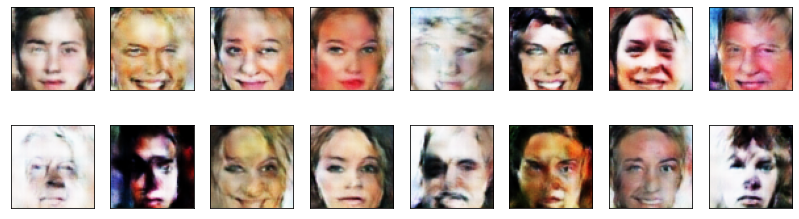

2023-11-24 10:41:59 | Epoch [11/20] | Batch 0/509 | d_loss: 0.4545 | g_loss: 4.2678
2023-11-24 10:42:05 | Epoch [11/20] | Batch 50/509 | d_loss: 0.3659 | g_loss: 3.4697
2023-11-24 10:42:11 | Epoch [11/20] | Batch 100/509 | d_loss: 0.4370 | g_loss: 3.2327
2023-11-24 10:42:18 | Epoch [11/20] | Batch 150/509 | d_loss: 0.4769 | g_loss: 6.0614
2023-11-24 10:42:24 | Epoch [11/20] | Batch 200/509 | d_loss: 0.4388 | g_loss: 5.0542
2023-11-24 10:42:31 | Epoch [11/20] | Batch 250/509 | d_loss: 0.3654 | g_loss: 4.4489
2023-11-24 10:42:38 | Epoch [11/20] | Batch 300/509 | d_loss: 0.3971 | g_loss: 2.7746
2023-11-24 10:42:45 | Epoch [11/20] | Batch 350/509 | d_loss: 2.4373 | g_loss: 7.9140
2023-11-24 10:42:51 | Epoch [11/20] | Batch 400/509 | d_loss: 0.4396 | g_loss: 3.5101
2023-11-24 10:42:58 | Epoch [11/20] | Batch 450/509 | d_loss: 0.4045 | g_loss: 3.9866
2023-11-24 10:43:04 | Epoch [11/20] | Batch 500/509 | d_loss: 0.4147 | g_loss: 3.6629


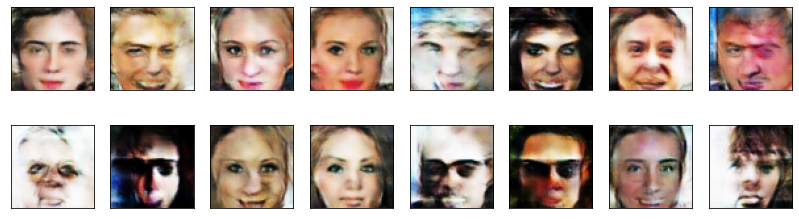

2023-11-24 10:43:10 | Epoch [12/20] | Batch 0/509 | d_loss: 0.4615 | g_loss: 3.8284
2023-11-24 10:43:16 | Epoch [12/20] | Batch 50/509 | d_loss: 0.5200 | g_loss: 4.0662
2023-11-24 10:43:23 | Epoch [12/20] | Batch 100/509 | d_loss: 0.5883 | g_loss: 3.0853
2023-11-24 10:43:29 | Epoch [12/20] | Batch 150/509 | d_loss: 0.6692 | g_loss: 4.2514
2023-11-24 10:43:35 | Epoch [12/20] | Batch 200/509 | d_loss: 0.4657 | g_loss: 4.0076
2023-11-24 10:43:42 | Epoch [12/20] | Batch 250/509 | d_loss: 0.6710 | g_loss: 3.4613
2023-11-24 10:43:48 | Epoch [12/20] | Batch 300/509 | d_loss: 0.3924 | g_loss: 3.7659
2023-11-24 10:43:54 | Epoch [12/20] | Batch 350/509 | d_loss: 1.1384 | g_loss: 4.8400
2023-11-24 10:44:01 | Epoch [12/20] | Batch 400/509 | d_loss: 0.3650 | g_loss: 3.2890
2023-11-24 10:44:07 | Epoch [12/20] | Batch 450/509 | d_loss: 0.4048 | g_loss: 5.1172
2023-11-24 10:44:13 | Epoch [12/20] | Batch 500/509 | d_loss: 0.3844 | g_loss: 4.2612


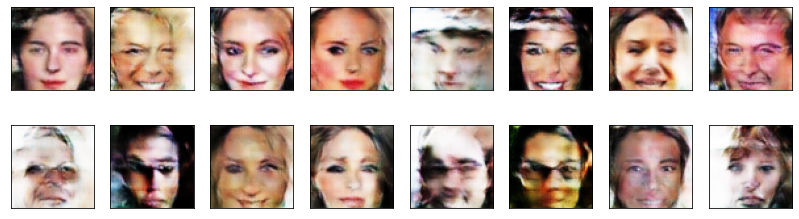

2023-11-24 10:44:18 | Epoch [13/20] | Batch 0/509 | d_loss: 0.4072 | g_loss: 3.9807
2023-11-24 10:44:25 | Epoch [13/20] | Batch 50/509 | d_loss: 0.5497 | g_loss: 3.6882
2023-11-24 10:44:31 | Epoch [13/20] | Batch 100/509 | d_loss: 0.3591 | g_loss: 4.7236
2023-11-24 10:44:38 | Epoch [13/20] | Batch 150/509 | d_loss: 0.4078 | g_loss: 4.7573
2023-11-24 10:44:45 | Epoch [13/20] | Batch 200/509 | d_loss: 0.4381 | g_loss: 3.5785
2023-11-24 10:44:51 | Epoch [13/20] | Batch 250/509 | d_loss: 0.5155 | g_loss: 4.8708
2023-11-24 10:44:58 | Epoch [13/20] | Batch 300/509 | d_loss: 0.3723 | g_loss: 3.7092
2023-11-24 10:45:05 | Epoch [13/20] | Batch 350/509 | d_loss: 0.4670 | g_loss: 3.5920
2023-11-24 10:45:11 | Epoch [13/20] | Batch 400/509 | d_loss: 0.4385 | g_loss: 4.2790
2023-11-24 10:45:18 | Epoch [13/20] | Batch 450/509 | d_loss: 0.3991 | g_loss: 2.6536
2023-11-24 10:45:24 | Epoch [13/20] | Batch 500/509 | d_loss: 0.3651 | g_loss: 4.7887


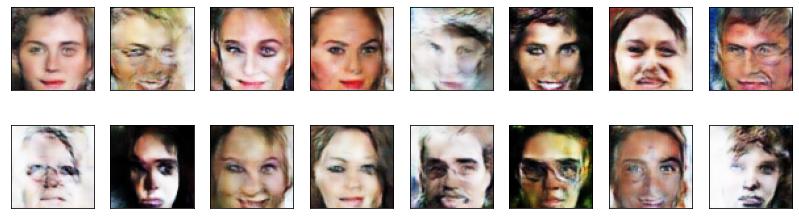

2023-11-24 10:45:28 | Epoch [14/20] | Batch 0/509 | d_loss: 0.3759 | g_loss: 3.9671
2023-11-24 10:45:34 | Epoch [14/20] | Batch 50/509 | d_loss: 0.4863 | g_loss: 4.6614
2023-11-24 10:45:41 | Epoch [14/20] | Batch 100/509 | d_loss: 0.3797 | g_loss: 5.5612
2023-11-24 10:45:47 | Epoch [14/20] | Batch 150/509 | d_loss: 0.3937 | g_loss: 4.5284
2023-11-24 10:45:54 | Epoch [14/20] | Batch 200/509 | d_loss: 0.3711 | g_loss: 3.3090
2023-11-24 10:46:00 | Epoch [14/20] | Batch 250/509 | d_loss: 0.4991 | g_loss: 2.3740
2023-11-24 10:46:06 | Epoch [14/20] | Batch 300/509 | d_loss: 0.3740 | g_loss: 4.1884
2023-11-24 10:46:13 | Epoch [14/20] | Batch 350/509 | d_loss: 0.3886 | g_loss: 5.6575
2023-11-24 10:46:19 | Epoch [14/20] | Batch 400/509 | d_loss: 0.3487 | g_loss: 6.8783
2023-11-24 10:46:26 | Epoch [14/20] | Batch 450/509 | d_loss: 0.4111 | g_loss: 3.5351
2023-11-24 10:46:33 | Epoch [14/20] | Batch 500/509 | d_loss: 0.3734 | g_loss: 3.7403


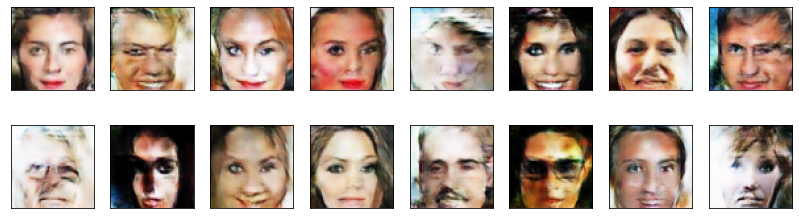

2023-11-24 10:46:38 | Epoch [15/20] | Batch 0/509 | d_loss: 0.4068 | g_loss: 4.2178
2023-11-24 10:46:44 | Epoch [15/20] | Batch 50/509 | d_loss: 0.3970 | g_loss: 3.6062
2023-11-24 10:46:51 | Epoch [15/20] | Batch 100/509 | d_loss: 0.3665 | g_loss: 4.7312
2023-11-24 10:46:58 | Epoch [15/20] | Batch 150/509 | d_loss: 0.9605 | g_loss: 5.5537
2023-11-24 10:47:04 | Epoch [15/20] | Batch 200/509 | d_loss: 0.6348 | g_loss: 2.8333
2023-11-24 10:47:11 | Epoch [15/20] | Batch 250/509 | d_loss: 0.4261 | g_loss: 3.4294
2023-11-24 10:47:17 | Epoch [15/20] | Batch 300/509 | d_loss: 0.3620 | g_loss: 4.0177
2023-11-24 10:47:24 | Epoch [15/20] | Batch 350/509 | d_loss: 0.4016 | g_loss: 3.4289
2023-11-24 10:47:30 | Epoch [15/20] | Batch 400/509 | d_loss: 0.4530 | g_loss: 4.1858
2023-11-24 10:47:36 | Epoch [15/20] | Batch 450/509 | d_loss: 0.3817 | g_loss: 5.3192
2023-11-24 10:47:43 | Epoch [15/20] | Batch 500/509 | d_loss: 0.4930 | g_loss: 5.1765


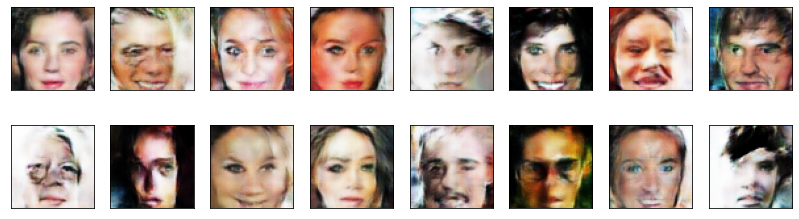

2023-11-24 10:47:47 | Epoch [16/20] | Batch 0/509 | d_loss: 0.3668 | g_loss: 3.8603
2023-11-24 10:47:53 | Epoch [16/20] | Batch 50/509 | d_loss: 0.3801 | g_loss: 3.7371
2023-11-24 10:47:59 | Epoch [16/20] | Batch 100/509 | d_loss: 0.3816 | g_loss: 3.3506
2023-11-24 10:48:06 | Epoch [16/20] | Batch 150/509 | d_loss: 0.5668 | g_loss: 3.9437
2023-11-24 10:48:12 | Epoch [16/20] | Batch 200/509 | d_loss: 0.3800 | g_loss: 4.5658
2023-11-24 10:48:19 | Epoch [16/20] | Batch 250/509 | d_loss: 0.6683 | g_loss: 2.1787
2023-11-24 10:48:25 | Epoch [16/20] | Batch 300/509 | d_loss: 0.4476 | g_loss: 5.1052
2023-11-24 10:48:31 | Epoch [16/20] | Batch 350/509 | d_loss: 0.3740 | g_loss: 4.8242
2023-11-24 10:48:38 | Epoch [16/20] | Batch 400/509 | d_loss: 0.5762 | g_loss: 4.7581
2023-11-24 10:48:44 | Epoch [16/20] | Batch 450/509 | d_loss: 0.4032 | g_loss: 3.3034
2023-11-24 10:48:51 | Epoch [16/20] | Batch 500/509 | d_loss: 0.3510 | g_loss: 3.3900


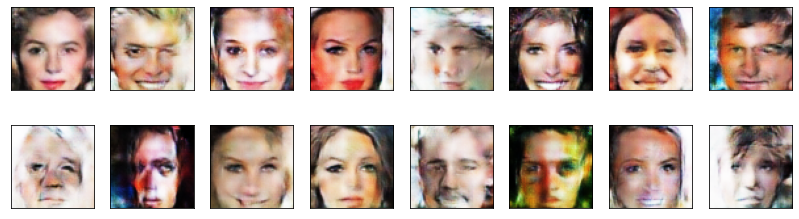

2023-11-24 10:48:56 | Epoch [17/20] | Batch 0/509 | d_loss: 0.3733 | g_loss: 4.5612
2023-11-24 10:49:03 | Epoch [17/20] | Batch 50/509 | d_loss: 0.3563 | g_loss: 3.8550
2023-11-24 10:49:10 | Epoch [17/20] | Batch 100/509 | d_loss: 0.3955 | g_loss: 4.9752
2023-11-24 10:49:16 | Epoch [17/20] | Batch 150/509 | d_loss: 0.4703 | g_loss: 4.2725
2023-11-24 10:49:23 | Epoch [17/20] | Batch 200/509 | d_loss: 0.5773 | g_loss: 3.3930
2023-11-24 10:49:29 | Epoch [17/20] | Batch 250/509 | d_loss: 0.4562 | g_loss: 3.5984
2023-11-24 10:49:36 | Epoch [17/20] | Batch 300/509 | d_loss: 0.3568 | g_loss: 3.5465
2023-11-24 10:49:43 | Epoch [17/20] | Batch 350/509 | d_loss: 0.4211 | g_loss: 3.6026
2023-11-24 10:49:49 | Epoch [17/20] | Batch 400/509 | d_loss: 1.4070 | g_loss: 7.3647
2023-11-24 10:49:55 | Epoch [17/20] | Batch 450/509 | d_loss: 0.3523 | g_loss: 2.9006
2023-11-24 10:50:01 | Epoch [17/20] | Batch 500/509 | d_loss: 0.5330 | g_loss: 3.3211


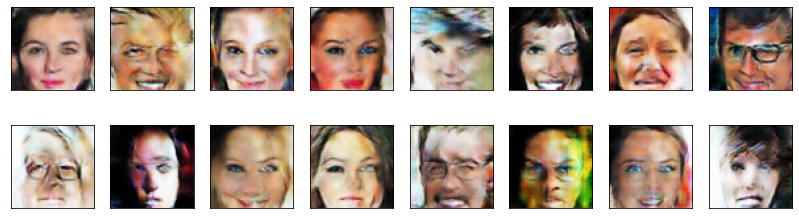

2023-11-24 10:50:06 | Epoch [18/20] | Batch 0/509 | d_loss: 0.5413 | g_loss: 3.6022
2023-11-24 10:50:13 | Epoch [18/20] | Batch 50/509 | d_loss: 0.3526 | g_loss: 3.8516
2023-11-24 10:50:19 | Epoch [18/20] | Batch 100/509 | d_loss: 0.4609 | g_loss: 4.0137
2023-11-24 10:50:25 | Epoch [18/20] | Batch 150/509 | d_loss: 0.5295 | g_loss: 3.1320
2023-11-24 10:50:32 | Epoch [18/20] | Batch 200/509 | d_loss: 0.4009 | g_loss: 4.6201
2023-11-24 10:50:38 | Epoch [18/20] | Batch 250/509 | d_loss: 0.3544 | g_loss: 3.5407
2023-11-24 10:50:45 | Epoch [18/20] | Batch 300/509 | d_loss: 0.6594 | g_loss: 5.5013
2023-11-24 10:50:51 | Epoch [18/20] | Batch 350/509 | d_loss: 0.6600 | g_loss: 2.5330
2023-11-24 10:50:58 | Epoch [18/20] | Batch 400/509 | d_loss: 0.4435 | g_loss: 4.7944
2023-11-24 10:51:05 | Epoch [18/20] | Batch 450/509 | d_loss: 0.5594 | g_loss: 3.8958
2023-11-24 10:51:11 | Epoch [18/20] | Batch 500/509 | d_loss: 0.5720 | g_loss: 4.4383


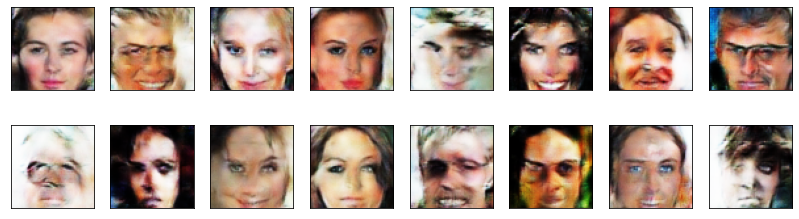

2023-11-24 10:51:16 | Epoch [19/20] | Batch 0/509 | d_loss: 0.3881 | g_loss: 4.1120
2023-11-24 10:51:23 | Epoch [19/20] | Batch 50/509 | d_loss: 0.3603 | g_loss: 4.1919
2023-11-24 10:51:29 | Epoch [19/20] | Batch 100/509 | d_loss: 0.4473 | g_loss: 4.1356
2023-11-24 10:51:36 | Epoch [19/20] | Batch 150/509 | d_loss: 0.3951 | g_loss: 3.5428
2023-11-24 10:51:43 | Epoch [19/20] | Batch 200/509 | d_loss: 0.4461 | g_loss: 4.1309
2023-11-24 10:51:49 | Epoch [19/20] | Batch 250/509 | d_loss: 0.5214 | g_loss: 4.1429
2023-11-24 10:51:55 | Epoch [19/20] | Batch 300/509 | d_loss: 0.4331 | g_loss: 5.0893
2023-11-24 10:52:01 | Epoch [19/20] | Batch 350/509 | d_loss: 0.5165 | g_loss: 3.0968
2023-11-24 10:52:08 | Epoch [19/20] | Batch 400/509 | d_loss: 0.4275 | g_loss: 4.7273
2023-11-24 10:52:14 | Epoch [19/20] | Batch 450/509 | d_loss: 0.3838 | g_loss: 4.8828
2023-11-24 10:52:20 | Epoch [19/20] | Batch 500/509 | d_loss: 0.5504 | g_loss: 3.6459


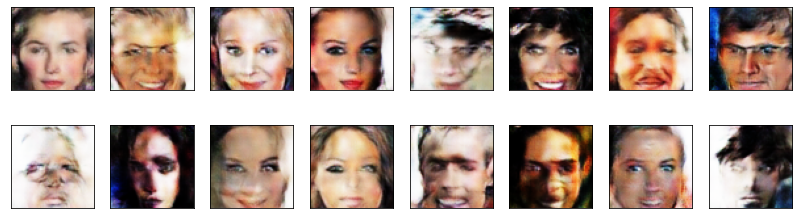

2023-11-24 10:52:25 | Epoch [20/20] | Batch 0/509 | d_loss: 1.0401 | g_loss: 9.1569
2023-11-24 10:52:32 | Epoch [20/20] | Batch 50/509 | d_loss: 0.3833 | g_loss: 4.2941
2023-11-24 10:52:38 | Epoch [20/20] | Batch 100/509 | d_loss: 0.4047 | g_loss: 4.5577
2023-11-24 10:52:45 | Epoch [20/20] | Batch 150/509 | d_loss: 0.4398 | g_loss: 2.5741
2023-11-24 10:52:51 | Epoch [20/20] | Batch 200/509 | d_loss: 0.4302 | g_loss: 4.9198
2023-11-24 10:52:58 | Epoch [20/20] | Batch 250/509 | d_loss: 0.3909 | g_loss: 3.4779
2023-11-24 10:53:04 | Epoch [20/20] | Batch 300/509 | d_loss: 0.3574 | g_loss: 6.8727
2023-11-24 10:53:11 | Epoch [20/20] | Batch 350/509 | d_loss: 0.3957 | g_loss: 3.3192
2023-11-24 10:53:18 | Epoch [20/20] | Batch 400/509 | d_loss: 0.4323 | g_loss: 5.2949
2023-11-24 10:53:24 | Epoch [20/20] | Batch 450/509 | d_loss: 1.2031 | g_loss: 1.1964
2023-11-24 10:53:31 | Epoch [20/20] | Batch 500/509 | d_loss: 0.4108 | g_loss: 3.7238


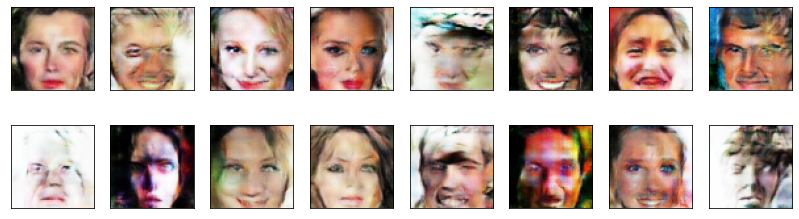

In [23]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

train_on_gpu = True
losses = []
# train the network
discriminator.train()
generator.train()

train_on_gpu = True
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # TRAIN THE GENERATOR
        g_loss = generator_step(batch_size, latent_dim)
        # TRAIN THE DISCRIMINATOR
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

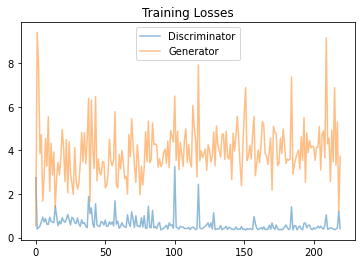

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.